<h1 align=center><font size = 6>Keystroke Dynamics - Benchmark Data Set </h1 > 

<h1 align=center><font size = 3>By: Kevin Machado Gamboa </h1>

<h1 align=center><font size = 3>Date: 21/09/2020</h1>

## Introduction

This Notebook is my personal contribution to the "Accompaniment to Comparing Anomaly-Detection Algorithms for Keystroke Dynamics", by Kevin Killourhy and Roy Maxion. For more information about this Database and its creators, please visit: https://www.cs.cmu.edu/~keystroke/.

#### Note
In order to run this Notebook correctly, the database **DSL-StrongPasswordData.csv** file should be in the same folder as the notebook.

#### References:

[1] Kevin S. Killourhy and Roy A. Maxion. "Comparing Anomaly Detectors for Keystroke Dynamics," in Proceedings of the 39th Annual International Conference on Dependable Systems and Networks (DSN-2009), pages 125-134, Estoril, Lisbon, Portugal, June 29-July 2, 2009. IEEE Computer Society Press, Los Alamitos, California, 2009. (pdf - http://www.cs.cmu.edu/~keystroke/KillourhyMaxion09.pdf)

[2] T. Sing, O. Sander, N. Beerenwinkel, T. Lengauer. "ROCR: visualizing classifier performance in R," Bioinformatics 21(20):3940-3941 (2005). (link - https://ipa-tys.github.io/ROCR/)

### Libraries Used

In [1]:
import numpy as np
import random as rd
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

### Functions implemented

In [2]:
def compute_eer(fpr,tpr,thresholds):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    fnr = 1-tpr
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((fpr[min_index], fnr[min_index]))
    return eer, thresholds[min_index]

def get_DD_time(X):
    """ Gets the DD times """
    vom = len(X.shape) # identify if vector '1' or if matrix '2'
    if vom == 1:       
        Y = [X[i] for i in range(0, len(X), 3)]
    elif vom == 2:
        Y = np.zeros([X.shape[0], 10])
        for j in range(X.shape[0]):
            Y[j,:] = [X[j][i] for i in range(0, len(X[j]), 3)]
    return np.array(Y)

def feature_vector(X):
    """ 
    1. get the dd times
    2. apply first derivative - velocity
    3. apply second derivative - acceleration
    """
    vom = len(X.shape) # identify if vector '1' or if matrix '2'
    # get the DD times
    y1 = get_DD_time(X)
    if vom == 1: 
        # get velocities
        vel = abs(np.diff(y1, prepend=y1[0]))
        #get accelerations
        acc = np.diff(vel, prepend=vel[0])
        
        return np.concatenate((np.concatenate((y1, vel)), acc)), np.array([y1, vel, acc])
    
    elif vom == 2:
        # get velocities
        vel = abs(np.diff(np.append(np.zeros([y1.shape[0],1]), y1, axis=1)))
        #get accelerations
        acc = np.diff(np.append(np.zeros([vel.shape[0],1]), vel, axis=1))
    
        return np.concatenate((np.concatenate((y1, vel), axis=1), acc), axis=1), np.array([y1, vel, acc])


# X-axes vector
x_pass = ['.-t', 't-i', 'i-e', 'e-5', '5-s-R', 'R-o', 'o-a', 'a-n', 'n-l', 'l-enter']

### Dataset Loading & Exploration

The dataset consist of keystroke-timing information from 51 subjects (typists), each typing a password (.tie5Roanl) 400 times. For each of the 51 subjects, the first 200 typing attempts should be used to train a model capturing the subject's individual typing behaviour. Given the 51 obtained models, the remaining 200 * 51 typing attempts should be used to compute the Equal Error Rate (EER), as a measure of performance.

In the next line I loaded the dataset

In [3]:
# Loading dataset
dataset = pd.read_csv('DSL-StrongPasswordData.csv')
dataset

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20395,s057,8,46,0.0884,0.0685,-0.0199,0.1095,0.1290,0.0195,0.0945,...,0.1219,0.1383,0.0164,0.0820,0.1329,0.0509,0.1005,0.2054,0.1049,0.1047
20396,s057,8,47,0.0655,0.0630,-0.0025,0.0910,0.1148,0.0238,0.0916,...,0.1008,0.0512,-0.0496,0.1037,0.0868,-0.0169,0.1445,0.2206,0.0761,0.1198
20397,s057,8,48,0.0939,0.1189,0.0250,0.1008,0.1122,0.0114,0.0721,...,0.0913,0.1169,0.0256,0.0689,0.1311,0.0622,0.1034,0.2017,0.0983,0.0905
20398,s057,8,49,0.0923,0.1294,0.0371,0.0913,0.0990,0.0077,0.0992,...,0.0882,0.0821,-0.0061,0.0576,0.0697,0.0121,0.0979,0.1917,0.0938,0.0931


Below we can check a basic statistical summary of the dataset

In [4]:
dataset.iloc[:,3:].describe()

,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,...,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000
mean,0.093379,0.264148,0.170769,0.085727,0.169085,0.083358,0.081565,0.159372,0.077806,0.089138,...,0.106259,0.150670,0.044411,0.089899,0.202630,0.112731,0.095589,0.321847,0.226259,0.088306
std,0.029626,0.220534,0.226836,0.027424,0.123546,0.125755,0.026887,0.226928,0.228512,0.030635,...,0.038828,0.107422,0.105197,0.030738,0.150191,0.159571,0.028348,0.225389,0.230759,0.027452
min,0.001400,0.018700,-0.235800,0.009300,0.001100,-0.162100,0.003200,0.001400,-0.160000,0.002100,...,0.004000,0.001100,-0.235500,0.003700,0.001300,-0.175800,0.003700,0.008300,-0.124500,0.002900
25%,0.074400,0.146900,0.049800,0.066000,0.113600,0.027200,0.062000,0.089300,0.007400,0.068600,...,0.082100,0.096100,-0.009000,0.067300,0.127600,0.023500,0.077400,0.210000,0.114100,0.069900
50%,0.089500,0.205950,0.108700,0.081000,0.140400,0.057800,0.077100,0.120900,0.041200,0.083400,...,0.101900,0.125000,0.022700,0.085300,0.172500,0.095500,0.093700,0.263000,0.160300,0.085500
75%,0.107900,0.306450,0.212400,0.099800,0.183900,0.096400,0.096900,0.173100,0.093400,0.102700,...,0.122300,0.174600,0.068900,0.107900,0.228800,0.145700,0.111100,0.350200,0.255100,0.103700
max,0.376100,12.506100,12.451700,0.241100,4.919700,4.799900,0.331200,25.987300,25.915800,0.325400,...,2.035300,3.327800,2.524200,0.357700,4.025200,3.978200,0.340700,5.883600,5.836400,0.265100


### Keystroke Dynamics - Typing Velocity and Acceleration
Lets analyse the keystroke dynamics in the first repetition of session 1, for example, in the subject s002:

In [5]:
dataset[(dataset['subject'] == 's002') & (dataset['sessionIndex'] == 1) & (dataset['rep'] == 1)]

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742


The first step in this analysis requires to extract all keydown-keydown times for this subject (culumn names of the form DD) during this present attempt. I implement this using the function **get_DD_times**.

In [6]:
all_times = dataset[(dataset['subject'] == 's002') & (dataset['sessionIndex'] == 1) & (dataset['rep'] == 1)].to_numpy()[0][4:]
DD = get_DD_time(all_times)
print('DD times in a single repetition', DD)

DD times in a single repetition [0.3979 0.1674 0.2212 1.1885 1.6055 0.759  0.2136 0.1484 0.3515 0.3509]


In the next graph we can check how the DD vector look like:

Text(0, 0.5, 'time (s)')

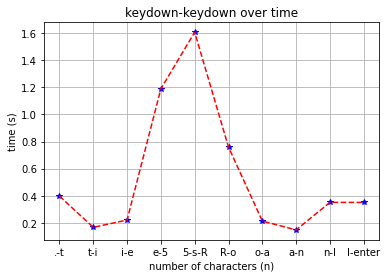

In [7]:
plt.plot(DD, '*b', DD, '--r', label = 'DD times')
plt.xticks(np.arange(10),x_pass, va='top')
plt.grid(True)
plt.title('keydown-keydown over time')
plt.xlabel('number of characters (n)')
plt.ylabel('time (s)')

Above we can visualize that **the time from when key 5 was pressed to when key 'shift r' was pressed is longer**. In fact, this can result in a obvious pattern given the password **'.tie5Roanl'**. In order to explore more, we can take 10 repetitions randonmy from the first 50 repetition in session 1 and look for any pattern.

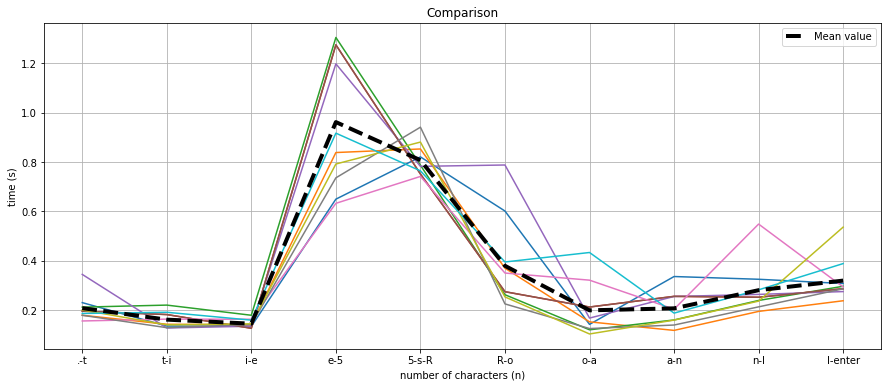

In [8]:
# Measuring Randonm repetitions
# First, select the 50 repetitions of session 1
AL = dataset[(dataset['subject']=='s002') & (dataset['sessionIndex'] == 1)].to_numpy()[:,4:]
DD_10 = []
plt.figure(figsize=(15,6))
for j in range(10):
    # random variable
    rv = rd.randint(0,49)
    # Get DD vector
    DD_10.append(get_DD_time(AL[rv]))
    plt.plot(DD_10[j])

plt.plot(np.mean(DD_10, axis=0), '--k', lw = 4, label= 'Mean value')
plt.xticks(np.arange(10),x_pass, va='top')    
plt.grid(True)
plt.title('Comparison')
plt.xlabel('number of characters (n)')
plt.ylabel('time (s)')
plt.legend()

In the graph above, the pattern illustrated now is that this subject takes more time **from when key e was pressed to when key '5' was pressed**. Lets re-affirm this patter by taking the first and the last 10 repetitions:

<ipython-input-9-81501fd77104>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,1)
<ipython-input-9-81501fd77104>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,2)
<ipython-input-9-81501fd77104>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retur

Text(0, 0.5, 'time (s)')

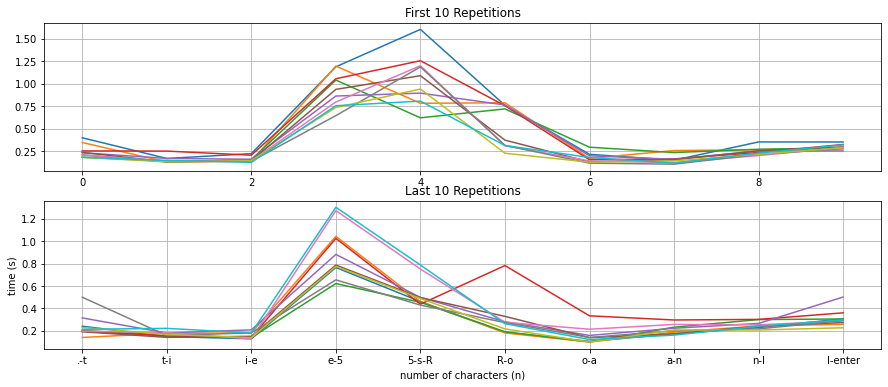

In [9]:
# Taking the first 10 and the last 10 repetitions from session 1

# First, select the 50 repetitions of session 1
AL = dataset[(dataset['subject']=='s002') & (dataset['sessionIndex'] == 1)].to_numpy()[:,4:]
DD_10_i = get_DD_time(AL[:10,:])  # for storing initial repetitions
DD_10_l = get_DD_time(AL[-10:,:])  # storing last 10 repetitions

plt.figure(figsize=(15,6))
for j in range(10):
    plt.subplot(2,1,1)
    plt.plot(DD_10_i[j])
    plt.subplot(2,1,2)
    plt.plot(DD_10_l[j])

plt.subplot(2,1,1)
plt.title('First 10 Repetitions')
plt.grid(True)
plt.subplot(2,1,2)
plt.title('Last 10 Repetitions')
plt.grid(True)

plt.xticks(np.arange(10),x_pass, va='top')
plt.xlabel('number of characters (n)')
plt.ylabel('time (s)')

The results shown in the graph above shows that, for this subject, the higher DD times changed from been the **5_shift_r** to **e-5** as more attempts are performed.

#### Typing Velocity and Acceleration
Now lets check the typing velocity and acceleration. To get full comprenhention of the importance of this variable we can recap the well-known concept of velocity from the physics point of view. In physics, to find the velocity of an object moving from point A to point B, you just needed to perform the derivative of the distance traveled at each instant of time. Similarly, the acceleration was just the derivative of the velocity. Coming back to what matters, we can find the velocity of typing the password each time every key is pressed. We can achieve this by just appliying the derivative to the vector 'DD' which in python can be achieved with the function diff from numpy; and the same for finding the acceleration. Lets check this again in our single repetition from subject s002:

In [10]:
# Getting the velocity
V_DD = np.diff(DD, prepend= DD[0]) # zero needs to be inserted as the initial value
print(V_DD)

[ 0.000e+00 -2.305e-01  5.380e-02  9.673e-01  4.170e-01 -8.465e-01
 -5.454e-01 -6.520e-02  2.031e-01 -6.000e-04]


We might be thinking, but why the velocity is negative? After thinking a bit I reminded from my physics courses that we always used the velocity in absolute values. This make sense because it just means that the veloccity passed from a higher to a lower value.

In [11]:
# absolute velocity
V_DD = abs(np.diff(DD, prepend=DD[0]))
# acceleration
A_DD = np.diff(V_DD, prepend=DD[0])

We can visualize the three vectors together bellow:

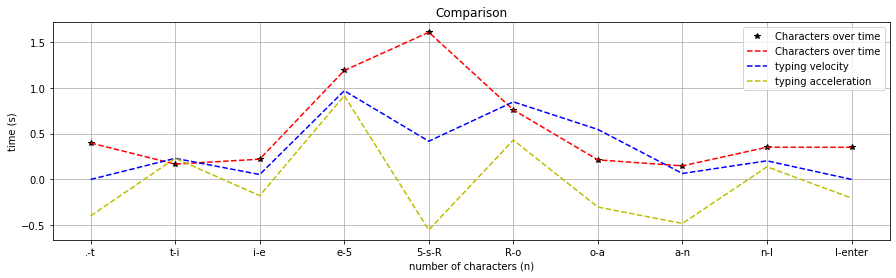

In [12]:
plt.figure(figsize=(15,4))
plt.plot(DD, '*k', DD, '--r', label = 'Characters over time')
plt.plot(V_DD, '--b', label= 'typing velocity')
plt.plot(A_DD, '--y', label='typing acceleration')
plt.xticks(np.arange(10),x_pass, va='top')    
plt.grid(True)
plt.title('Comparison')
plt.xlabel('number of characters (n)')
plt.ylabel('time (s)')
plt.legend()

### Feature Vector
Finally, with all this analysis we can create our feature vector (FV). This FV would be the input for our model and it will contain the three vectors from the graph before, vertically stacked: the DD time vector extracted from the database, vertically sttacked with its first and second derivative (its velocity and acceleration respectivally). 

Text(0, 0.5, 'time (s)')

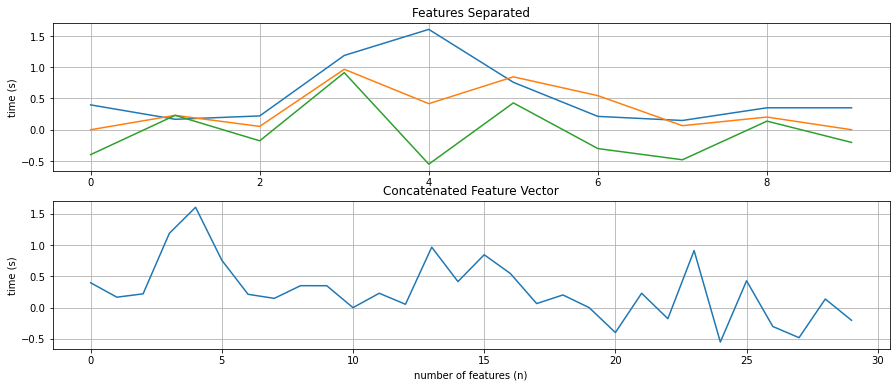

In [13]:
# Concatenating the three vectors 
FV = np.concatenate((np.concatenate((DD, V_DD)), A_DD))
# Graphs
plt.figure(figsize=(15,6))
# Vectors separated
plt.subplot(2,1,1)
plt.plot(DD)
plt.plot(V_DD)
plt.plot(A_DD)
plt.grid(True)
plt.title('Features Separated')
plt.ylabel('time (s)')
# Vectors concatenated
plt.subplot(2,1,2)
plt.plot(FV)
plt.grid(True)
plt.title('Concatenated Feature Vector')
plt.xlabel('number of features (n)')
plt.ylabel('time (s)')

Our feature vector can be extracted using the function **feature_vector**
### Database Preparation
The next step is to prepare the database to train our model. This preparation consist in split the data into training set and validation set.

In [14]:
# getting each subject code (ID)
scode = dataset['subject'].value_counts().index.to_numpy()
# Initializing training & validation set variable
labels = np.zeros([200, 51])

trainset = []     # training variable initialization
train_l = []      # training labels variable initialization
valset = []       # validation variable initialization
val_l = []        # validation labels variable initialization

# Training & Validation acquisition loop
for i, n in enumerate(scode):
    # getting training feature vector
    fv_t,_ = feature_vector(dataset[(dataset['subject']== n) & (dataset['sessionIndex']<5)].to_numpy()[:,4:])
    # Adding training & validation sets
    trainset.append(fv_t)
    # getting validation feature vector
    fv_v,_ = feature_vector(dataset[(dataset['subject']== n) & (dataset['sessionIndex']>4)].to_numpy()[:,4:])
    valset.append(fv_v)
    # Adding labels
    k = np.zeros([200, 51])
    k[:,i] = 1
    train_l.append(k)
    val_l.append(k)
    
print('Training Set Shape: ', np.shape(trainset), 'train labels shape: ', np.shape(train_l))
print('Validation Set Shape: ', np.shape(trainset), 'validation labels shape: ', np.shape(val_l))

Training Set Shape:  (51, 200, 30) train labels shape:  (51, 200, 51)
Validation Set Shape:  (51, 200, 30) validation labels shape:  (51, 200, 51)


The dimension printed before corresponds to 51 subjects, 200 typing attemps each and the 30 extracted features, in both training and validation set. This way in easier when performing the evaluation of the models. 

In order to perform each model evaluation with respect to the remaining 200 * 51 typing attempts, I performed a vertical-stack in the validation set. Here we end up with the final long-validation datasets and labels.

In [15]:
val_data = tf.convert_to_tensor(np.vstack(valset), dtype=tf.float32)
val_labels = np.vstack(val_l)

## Model Development
The model developed was the Multylayer Perceptron. This model is well known as a universal function aproximator. The model architecture is composed by three layers of 100 neurons each layer. It was performed with Adam optimizer and the mean-square-error as the loss function.

The input size to the model corresponds to all of the 31 timing information for the password.

In [16]:
# model input size 
in_size = val_data.shape[1]
# model architecture
def AD_model_1():
    model = tf.keras.Sequential ([
        tf.keras.layers.Dense(100, activation='relu', input_shape=([in_size,])),  
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Model Parameters
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer=opt,
                 loss='mse',
                 metrics=['accuracy'])
    return model
# features for training the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
# Model summary
model_1 = AD_model_1()
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 23,401
Trainable params: 23,401
Non-trainable params: 0
_________________________________________________________________


In the following cell we perform the model training, validation and EER evaluation

Epoch 1/20
20/20 [==============================] - 2s 117ms/step - loss: 0.0943 - accuracy: 1.0000 - val_loss: 0.7616 - val_accuracy: 0.0196
Epoch 2/20
20/20 [==============================] - 2s 121ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9380 - val_accuracy: 0.0196
Epoch 3/20
20/20 [==============================] - 2s 105ms/step - loss: 3.3514e-05 - accuracy: 1.0000 - val_loss: 0.9522 - val_accuracy: 0.0196
Epoch 4/20
20/20 [==============================] - 2s 103ms/step - loss: 1.7773e-05 - accuracy: 1.0000 - val_loss: 0.9544 - val_accuracy: 0.0196
Epoch 5/20
20/20 [==============================] - 2s 100ms/step - loss: 1.5324e-05 - accuracy: 1.0000 - val_loss: 0.9553 - val_accuracy: 0.0196
Epoch 6/20
20/20 [==============================] - 2s 107ms/step - loss: 1.4227e-05 - accuracy: 1.0000 - val_loss: 0.9559 - val_accuracy: 0.0196
Epoch 1/20
20/20 [==============================] - 2s 108ms/step - loss: 1.9035e-04 - accuracy: 1.0000 - val_loss: 0.9606 - val_acc

20/20 [==============================] - 2s 96ms/step - loss: 2.5416e-08 - accuracy: 1.0000 - val_loss: 0.9800 - val_accuracy: 0.0196
Epoch 6/20
20/20 [==============================] - 2s 99ms/step - loss: 2.5134e-08 - accuracy: 1.0000 - val_loss: 0.9800 - val_accuracy: 0.0196
Epoch 1/20
20/20 [==============================] - 2s 99ms/step - loss: 1.7023e-08 - accuracy: 1.0000 - val_loss: 0.9800 - val_accuracy: 0.0196
Epoch 2/20
20/20 [==============================] - 2s 96ms/step - loss: 1.6862e-08 - accuracy: 1.0000 - val_loss: 0.9800 - val_accuracy: 0.0196
Epoch 3/20
20/20 [==============================] - 2s 96ms/step - loss: 1.6715e-08 - accuracy: 1.0000 - val_loss: 0.9800 - val_accuracy: 0.0196
Epoch 4/20
20/20 [==============================] - 2s 95ms/step - loss: 1.6565e-08 - accuracy: 1.0000 - val_loss: 0.9800 - val_accuracy: 0.0196
Epoch 5/20
20/20 [==============================] - 2s 97ms/step - loss: 1.6406e-08 - accuracy: 1.0000 - val_loss: 0.9800 - val_accuracy: 0.0

20/20 [==============================] - 2s 98ms/step - loss: 6.4277e-10 - accuracy: 1.0000 - val_loss: 0.9801 - val_accuracy: 0.0196
Epoch 4/20
20/20 [==============================] - 2s 96ms/step - loss: 6.4185e-10 - accuracy: 1.0000 - val_loss: 0.9801 - val_accuracy: 0.0196
Epoch 5/20
20/20 [==============================] - 2s 95ms/step - loss: 6.4105e-10 - accuracy: 1.0000 - val_loss: 0.9801 - val_accuracy: 0.0196
Epoch 6/20
20/20 [==============================] - 2s 96ms/step - loss: 6.4010e-10 - accuracy: 1.0000 - val_loss: 0.9801 - val_accuracy: 0.0196
Epoch 1/20
20/20 [==============================] - 2s 97ms/step - loss: 6.2313e-08 - accuracy: 1.0000 - val_loss: 0.9801 - val_accuracy: 0.0196
Epoch 2/20
20/20 [==============================] - 2s 97ms/step - loss: 5.9138e-08 - accuracy: 1.0000 - val_loss: 0.9801 - val_accuracy: 0.0196
Epoch 3/20
20/20 [==============================] - 2s 95ms/step - loss: 5.4742e-08 - accuracy: 1.0000 - val_loss: 0.9802 - val_accuracy: 0.0

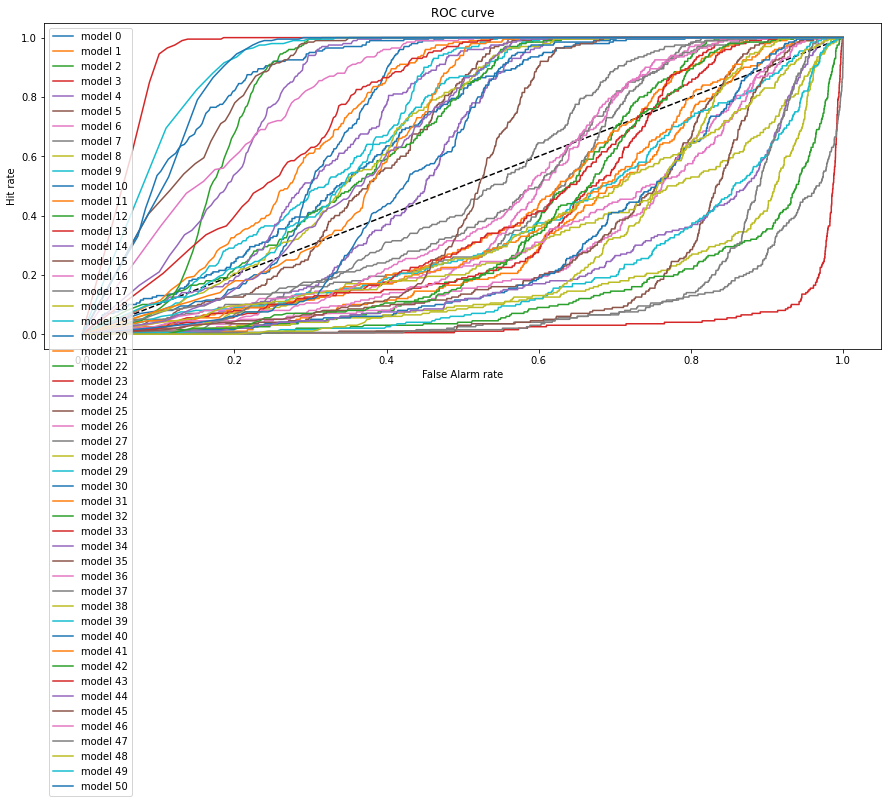

In [17]:
# Initializing variables
models = []    # Store each of the 51 models per subject
history = []   # Store each model history
eer = []       # Store each EER

plt.figure(figsize=(15,6))
plt.plot([0, 1], [0, 1], 'k--')

for i in range(51):
    models.append(model_1)
    
    history.append(models[i].fit(tf.convert_to_tensor(trainset[i], dtype=tf.float32), train_l[i][:,i],
                               epochs=20, batch_size=10, validation_data=(val_data, val_labels[:,i]), callbacks = [early_stop]))
    
    predictions = models[i].predict(val_data).ravel()
    fpr, tpr, threshold = roc_curve(val_labels[:,i], predictions)
    eer.append(compute_eer(fpr,tpr,threshold)[0])
    plt.plot(fpr, tpr, label='model '+ str(i))
    
plt.xlabel('False Alarm rate')
plt.ylabel('Hit rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Results
The mean **eer** value was 0.516. The minimum and maximun value achieved by a model was 0.126 and 0.915 respectively.

In [18]:
pd.DataFrame(eer).describe()

,0
count,51.000000
mean,0.513453
std,0.201858
min,0.078050
25%,0.375675
50%,0.567850
75%,0.637675
max,0.919900


### Conclusions

In this assignment, the Keystroke Dynamics - Benchmark Data Set was used to train a model to capture individual subject's typing behaviours. The EER was found as performed in ref[1] (EER = 0.513) and resulted higher than in the homework assignment #1

In this Notebook, a quick data analysis was performed and feature where extracted from the database. These features were: the vector of keydown-keydown times (DD.key1.key2), its first and second derivative (velocity and acceleration respectively). However, other features can be extracted from the database, including the hold times (H.key), the keyup-keydown times (UD.key1.key2) and the combination between them.

Supervise models such as the MLP gives predictions just when given the whole password. However, we can try generating predictions from when the first character is pressed, all the way to when the last character and the enter key is pressed. This can be achieved with models able to perform Sequence-to-Sequence predictions such as Hidden Markov Models (HMM) or Long Short-Term Memory (LSTM) neural networks. 